# Classifier calibration

In [4]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss



# What is Classifier Calibration?
Calibration refers to the ability of a model to produce probability scores that
accurately reflect the true likelihood of an event. For a perfectly calibrated
model, a prediction of 0.70 means there is a 70% chance that the positive
class will occur.

## Why is it important?
Many real-world applications rely on the *probability* of an outcome, not just
the class prediction. For example, in fraud detection, a bank might only
investigate transactions with a probability of fraud above a certain threshold.
If the model is poorly calibrated, these probabilities are unreliable, leading
to poor decision-making.

Some models, like Logistic Regression, are naturally well-calibrated. Others,
especially complex models like Random Forest or Gradient Boosting, are often
poorly calibrated because they can be overconfident or underconfident in their
predictions.

Let's see how it's done.

Before you proceed you might find reading the Sklearn [documentation](https://scikit-learn.org/stable/modules/calibration.html) helpful


In [ ]:
# Generate a synthetic dataset for a binary classification problem.
# We'll create 10,000 samples with 20 features, 10 of which are informative.
X, y = make_classification(
    n_samples=10000,
    n_features=20,
    n_informative=10,
    n_redundant=10,
    random_state=42
)

# Split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

Training uncalibrated models...


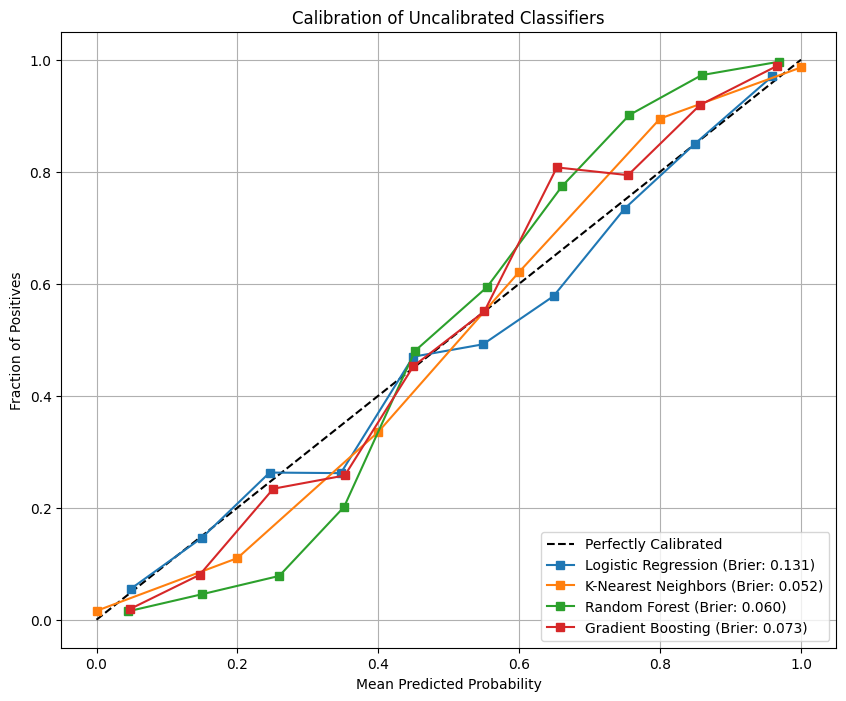

In [9]:
# Define the classifiers to be used.
# Logistic Regression is typically well-calibrated.
# Random Forest and K-Nearest Neighbors are often poorly calibrated.
# Gradient Boosting is a powerful ensemble method that can also be poorly calibrated.
uncalibrated_classifiers = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
}

print("Training uncalibrated models...")
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot([0, 1], [0, 1], "k--", label="Perfectly Calibrated")

# Loop through and train each uncalibrated classifier
for name, clf in uncalibrated_classifiers.items():
    clf.fit(X_train, y_train)
    # Get predicted probabilities for the test set
    prob_pos = clf.predict_proba(X_test)[:, 1]
    
    # Calculate calibration curve (fraction of positives vs. mean predicted value)
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_test, prob_pos, n_bins=10
    )
    
    # Calculate Brier Score Loss (lower is better, 0.0 means perfect calibration)
    brier = brier_score_loss(y_test, prob_pos)
    
    # Plot the calibration curve
    ax.plot(mean_predicted_value, fraction_of_positives, "s-", label=f"{name} (Brier: {brier:.3f})")

ax.set_title("Calibration of Uncalibrated Classifiers")
ax.set_xlabel("Mean Predicted Probability")
ax.set_ylabel("Fraction of Positives")
ax.set_ylim([-.05, 1.05])
ax.legend(loc="lower right")
ax.grid(True)
plt.show()




Calibrating models and plotting new results...


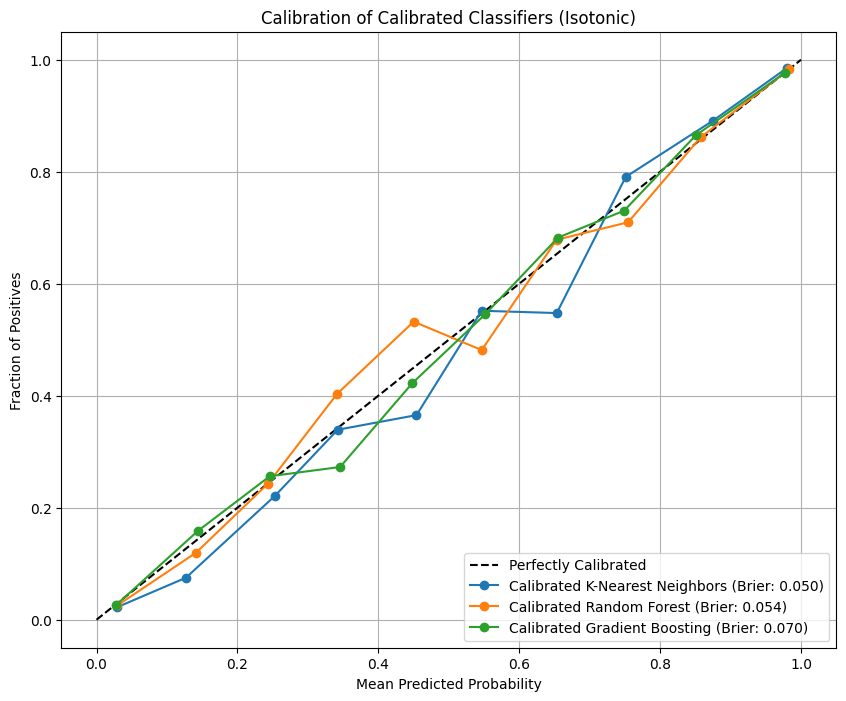

In [12]:
print("\nCalibrating models and plotting new results...")
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot([0, 1], [0, 1], "k--", label="Perfectly Calibrated")

# We will use Isotonic regression and Sigmoid methods for calibration
calibration_methods = {
    "Isotonic": "isotonic",
    "Sigmoid": "sigmoid"
}

# The best calibration method depends on the data. Isotonic is non-parametric
# and works best when there is enough data. Sigmoid is parametric and less
# prone to overfitting with small datasets.

for name, clf in uncalibrated_classifiers.items():
    if name == "Logistic Regression":
        # Logistic Regression is a good baseline, but doesn't need calibration
        continue
    
    # Use CalibratedClassifierCV to calibrate the model's probabilities
    # We use 'cv=5' for cross-validation on the training set.
    # The isotonic method is generally preferred if there is enough data.
    calibrated_clf = CalibratedClassifierCV(
        clf, method='isotonic', cv=5
    )
    
    # Fit the calibrated model on the training data.
    calibrated_clf.fit(X_train, y_train)
    
    # Get predicted probabilities from the calibrated model.
    prob_pos = calibrated_clf.predict_proba(X_test)[:, 1]
    
    # Calculate the new calibration curve
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_test, prob_pos, n_bins=10
    )
    
    # Calculate the new Brier Score Loss
    brier = brier_score_loss(y_test, prob_pos)
    
    # Plot the new calibration curve
    ax.plot(mean_predicted_value, fraction_of_positives, "o-", label=f"Calibrated {name} (Brier: {brier:.3f})")

ax.set_title("Calibration of Calibrated Classifiers (Isotonic)")
ax.set_xlabel("Mean Predicted Probability")
ax.set_ylabel("Fraction of Positives")
ax.set_ylim([-.05, 1.05])
ax.legend(loc="lower right")
ax.grid(True)
plt.show()



Plotting comparison of uncalibrated vs. calibrated for each classifier...


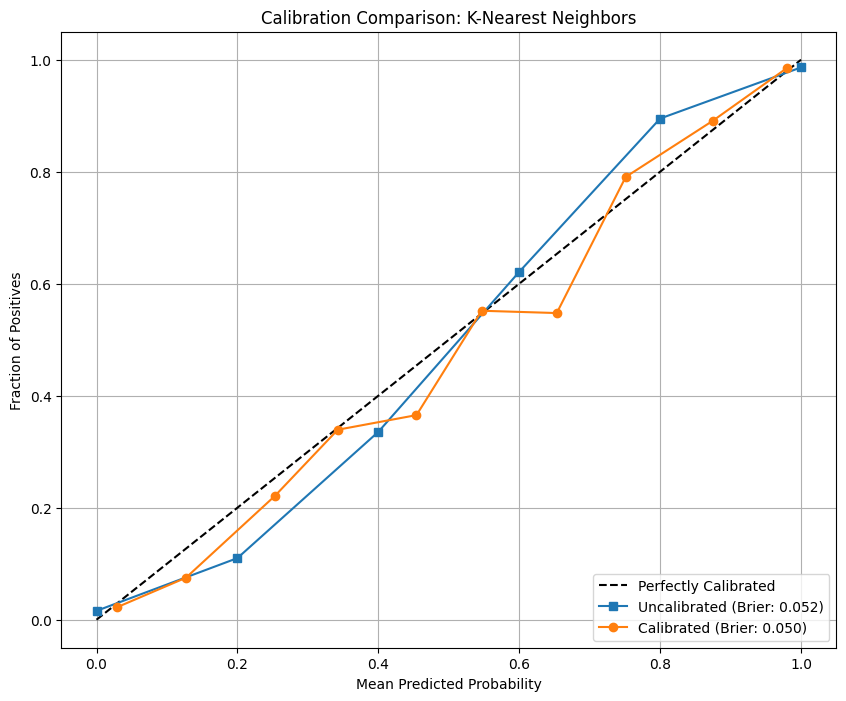

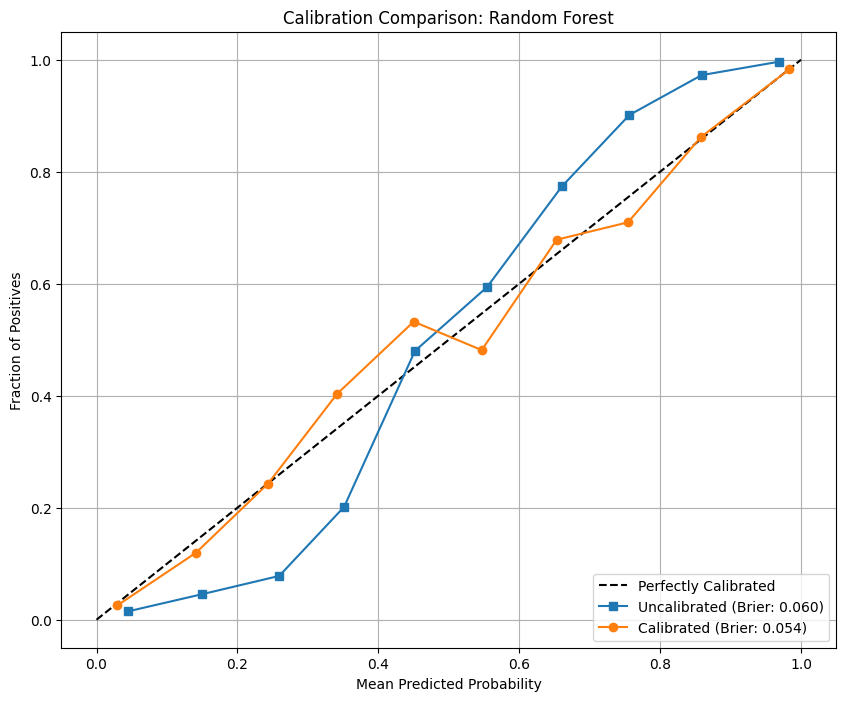

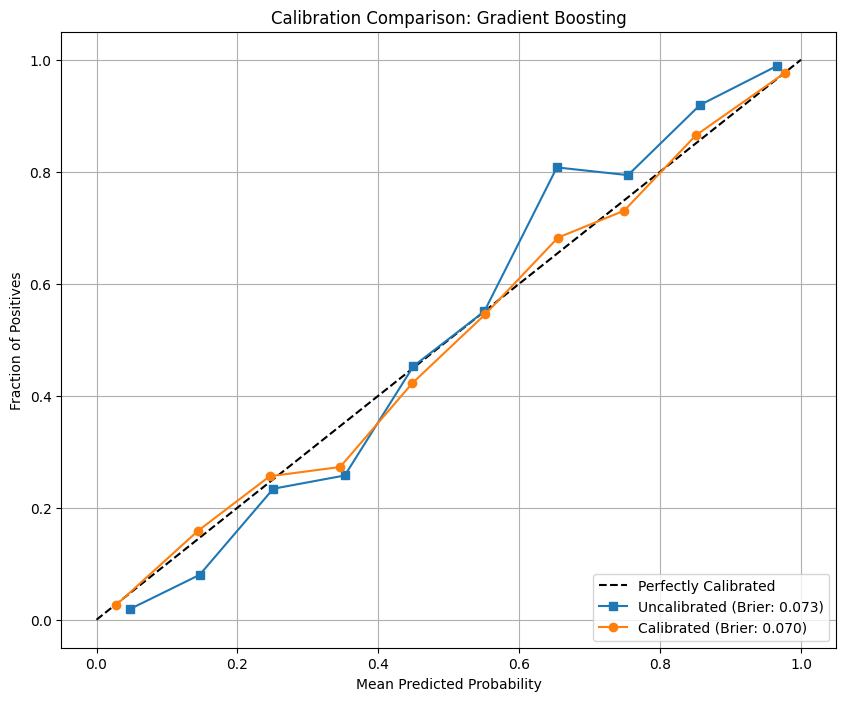

In [13]:
print("\nPlotting comparison of uncalibrated vs. calibrated for each classifier...")

for name, clf in uncalibrated_classifiers.items():
    if name == "Logistic Regression":
        continue

    # Create a new figure for each classifier
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.plot([0, 1], [0, 1], "k--", label="Perfectly Calibrated")

    # --- Plot Uncalibrated Version ---
    clf.fit(X_train, y_train)
    prob_pos_uncalibrated = clf.predict_proba(X_test)[:, 1]
    fraction_of_positives_uncalibrated, mean_predicted_value_uncalibrated = calibration_curve(
        y_test, prob_pos_uncalibrated, n_bins=10
    )
    brier_uncalibrated = brier_score_loss(y_test, prob_pos_uncalibrated)
    ax.plot(
        mean_predicted_value_uncalibrated, 
        fraction_of_positives_uncalibrated, 
        "s-", 
        label=f"Uncalibrated (Brier: {brier_uncalibrated:.3f})"
    )

    # --- Plot Calibrated Version ---
    calibrated_clf = CalibratedClassifierCV(clf, method='isotonic', cv=5)
    calibrated_clf.fit(X_train, y_train)
    prob_pos_calibrated = calibrated_clf.predict_proba(X_test)[:, 1]
    fraction_of_positives_calibrated, mean_predicted_value_calibrated = calibration_curve(
        y_test, prob_pos_calibrated, n_bins=10
    )
    brier_calibrated = brier_score_loss(y_test, prob_pos_calibrated)
    ax.plot(
        mean_predicted_value_calibrated, 
        fraction_of_positives_calibrated, 
        "o-", 
        label=f"Calibrated (Brier: {brier_calibrated:.3f})"
    )

    ax.set_title(f"Calibration Comparison: {name}")
    ax.set_xlabel("Mean Predicted Probability")
    ax.set_ylabel("Fraction of Positives")
    ax.set_ylim([-.05, 1.05])
    ax.legend(loc="lower right")
    ax.grid(True)
    plt.show()